In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
traindata = pd.read_csv("/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageClef-2019-VQA-Med-Training/All_QA_Pairs_train.txt", sep = "|", header = None)
traindata.columns = ["image_id", "question", "answer"]
traindata['answer'] = traindata['answer'].str.strip().str.replace('\s+', ' ', regex=True).str.lower()
traindata['question'] = traindata['question'].str.lower()
traindata['address'] = "/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageClef-2019-VQA-Med-Training/Train_images/" + traindata['image_id'] + ".jpg"
traindata

,image_id,question,answer,address
0,synpic41148,what kind of image is this?,cta - ct angiography,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
1,synpic43984,is this a t1 weighted image?,no,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
2,synpic38930,what type of imaging modality is used to acqui...,us - ultrasound,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
3,synpic52143,is this a noncontrast mri?,no,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
4,synpic20934,what type of image modality is this?,xr - plain film,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
...,...,...,...,...
12787,synpic35685,is this image normal?,yes,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
12788,synpic35687,is there something wrong in the image?,no,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
12789,synpic35701,is there evidence of any abnormalities?,no,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
12790,synpic48036,is the ct scan normal?,yes,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...


In [3]:
labels = traindata["answer"].value_counts()[traindata["answer"].value_counts() > 10] # Using a threshold of 10 for keeping labels with value counts more than 10
labels.keys()[:10]

Index(['axial', 'skull and contents', 'no', 'yes', 'sagittal',
       'xr - plain film', 'musculoskeletal', 'coronal', 'gastrointestinal',
       'lung, mediastinum, pleura'],
      dtype='object', name='answer')

In [4]:
# Removing rows containing minority classes.

for i in tqdm(range(len(traindata['answer']))):
    if traindata['answer'][i] not in labels.keys():
        traindata = traindata.drop(i)
traindata.reset_index(drop = True, inplace = True)
len(traindata)

100%|██████████| 12792/12792 [00:04<00:00, 2950.25it/s]


9866

In [5]:
valdata = pd.read_csv("/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageClef-2019-VQA-Med-Validation/All_QA_Pairs_val.txt", sep = "|", header = None)
valdata.columns = ["image_id", "question", "answer"]
valdata['answer'] = valdata['answer'].str.strip().str.replace('\s+', ' ', regex=True).str.lower()
valdata['question'] = valdata['question'].str.lower()
valdata['address'] = "/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageClef-2019-VQA-Med-Validation/Val_images/" + valdata['image_id'] + ".jpg"
valdata

,image_id,question,answer,address
0,synpic54733,what imaging modality was used to take this im...,ct with iv contrast,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
1,synpic25647,what kind of scan is this?,xr - plain film,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
2,synpic35681,was the mri taken with contrast?,no,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
3,synpic39641,"is this a t1 weighted, t2 weighted, or flair i...",t2,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
4,synpic35693,is this a noncontrast mri?,yes,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
...,...,...,...,...
1995,synpic45828,what is abnormal in the mri?,marked hydrocephalus due to aqueductal stenosis,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
1996,synpic60458,what is abnormal in the x-ray?,discoid meniscus,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
1997,synpic43524,what is most alarming about this mri?,"choroid plexus neoplasm, papilloma, carcinoma",/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...
1998,synpic59568,what is abnormal in the mri?,multiple sclerosis,/kaggle/input/vqa-med-2019/VQA-Med-2019/ImageC...


In [6]:
# Removing rows with minority classes.

for i in tqdm(range(len(valdata['answer']))):
    if valdata['answer'][i] not in labels.keys():
        valdata = valdata.drop(i)
valdata.reset_index(drop = True, inplace = True)
len(valdata)

100%|██████████| 2000/2000 [00:00<00:00, 7808.44it/s] 


1543

In [7]:
testdata = pd.read_csv("/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed2019Test/VQAMed2019_Test_Questions_w_Ref_Answers.txt", sep = "|", header = None)
testdata.columns = ["image_id", "type","question", "answer"]
testdata['answer'] = testdata['answer'].str.strip().str.replace('\s+', ' ', regex=True).str.lower()
testdata['question'] = testdata['question'].str.lower()
testdata['address'] = "/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed2019Test/VQAMed2019_Test_Images/" + testdata['image_id'] + ".jpg"
testdata

,image_id,type,question,answer,address
0,synpic54082,modality,what modality is shown?,cta - ct angiography,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...
1,synpic48556,modality,was the mri taken with contrast?,no,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...
2,synpic50696,modality,what type of contrast did this patient have?,iv,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...
3,synpic37194,modality,what imaging method was used?,us-d - doppler ultrasound,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...
4,synpic31308,modality,what modality is shown?,an - angiogram,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...
...,...,...,...,...,...
495,synpic21789,abnormality,what is abnormal in the ct scan?,ossification of stylohyoid ligament,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...
496,synpic39878,abnormality,what is most alarming about this mri?,cerebral infarct,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...
497,synpic41525,abnormality,what is most alarming about this ct scan?,epiploic appendagitis,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...
498,synpic18173,abnormality,what is the primary abnormality in this image?,pancreatic ductal adenocarcinoma,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...


In [8]:
# Removing rows with minority classes.

for i in tqdm(range(len(testdata['answer']))):
    if testdata['answer'][i] not in labels.keys():
        testdata = testdata.drop(i)
testdata.reset_index(drop = True, inplace = True)
len(testdata)

100%|██████████| 500/500 [00:00<00:00, 9343.39it/s]


381

In [9]:
len(traindata["answer"].value_counts()), len(valdata["answer"].value_counts()), len(testdata["answer"].value_counts()) 

(69, 64, 53)

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Add other preprocessing steps as needed (e.g., punctuation removal, stemming, etc.)
    return text

tqdm.pandas(desc="Preprocessing traindata")
traindata["question"] = traindata["question"].progress_apply(preprocess_text)

tqdm.pandas(desc="Preprocessing traindata")
valdata["question"] = valdata["question"].progress_apply(preprocess_text)

# Apply text preprocessing to valdata with tqdm progress bar
tqdm.pandas(desc="Preprocessing valdata")
testdata["question"] = testdata["question"].progress_apply(preprocess_text)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


Preprocessing valdata: 100%|██████████| 381/381 [00:00<00:00, 209275.78it/s]


## LABEL ENCODING

In [11]:
train_labels_df = pd.get_dummies(traindata['answer'], dtype = int)
train_labels = np.array(train_labels_df)
train_labels, train_labels.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]]),
 (9866, 69))

In [12]:
decoded_labels = []
for idx in np.argmax(np.array(train_labels), axis = 1):
    decoded_labels.append(train_labels_df.columns[idx])
decoded_labels[:10], traindata['answer'][:10]

(['cta - ct angiography',
  'no',
  'us - ultrasound',
  'no',
  'xr - plain film',
  'xr - plain film',
  'xr - plain film',
  'noncontrast',
  'yes',
  't2'],
 0    cta - ct angiography
 1                      no
 2         us - ultrasound
 3                      no
 4         xr - plain film
 5         xr - plain film
 6         xr - plain film
 7             noncontrast
 8                     yes
 9                      t2
 Name: answer, dtype: object)

In [13]:
val_labels_df = pd.DataFrame(np.zeros((len(valdata), 69)), columns = train_labels_df.columns)
for i in range(len(valdata)):
    val_labels_df[valdata['answer'][i]][i] = 1
val_labels = np.array(val_labels_df)
val_labels, val_labels.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (1543, 69))

In [14]:
decoded_labels = []
for idx in np.argmax(np.array(val_labels), axis = 1):
    decoded_labels.append(val_labels_df.columns[idx])
decoded_labels[:10], valdata['answer'][:10]

(['ct with iv contrast',
  'xr - plain film',
  'no',
  't2',
  'yes',
  'yes',
  'iv',
  'no',
  'xr - plain film',
  'no'],
 0    ct with iv contrast
 1        xr - plain film
 2                     no
 3                     t2
 4                    yes
 5                    yes
 6                     iv
 7                     no
 8        xr - plain film
 9                     no
 Name: answer, dtype: object)

In [15]:
test_labels_df = pd.DataFrame(np.zeros((len(testdata), 69)), columns = train_labels_df.columns)
for i in range(len(testdata)):
    test_labels_df[testdata['answer'][i]][i] = 1
test_labels = np.array(test_labels_df)
test_labels, test_labels.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (381, 69))

In [16]:
decoded_labels = []
for idx in np.argmax(np.array(test_labels), axis = 1):
    decoded_labels.append(test_labels_df.columns[idx])
decoded_labels[:10], testdata['answer'][:10]

(['cta - ct angiography',
  'no',
  'iv',
  'us-d - doppler ultrasound',
  'an - angiogram',
  't2',
  'yes',
  'gi and iv',
  'yes',
  'yes'],
 0         cta - ct angiography
 1                           no
 2                           iv
 3    us-d - doppler ultrasound
 4               an - angiogram
 5                           t2
 6                          yes
 7                    gi and iv
 8                          yes
 9                          yes
 Name: answer, dtype: object)

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

docx = np.array(traindata["question"].tolist())
docx2 = np.array(valdata["question"].tolist())
docx3 = np.array(testdata["question"].tolist())

tokenizer = Tokenizer(oov_token = "<nothing>")
tokenizer.fit_on_texts(docx)

sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding = "post", maxlen = 35)

sequences2 = tokenizer.texts_to_sequences(docx2)
sequences2 = pad_sequences(sequences2, padding = "post", maxlen = 35)

sequences3 = tokenizer.texts_to_sequences(docx3)
sequences3 = pad_sequences(sequences3, padding = "post", maxlen = 35)

2024-04-06 10:39:14.645790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 10:39:14.645935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 10:39:14.889323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
def augment_data(tup, label):
    image, sequence = tup
    # Randomly rotate the image (within a range of -20 to 20 degrees)
    angle = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32)
    image = tf.image.rot90(image, tf.cast(angle / 90, dtype=tf.int32))
    
    # Randomly shift the width and height
    shift_x = tf.random.uniform(shape=[], minval=-30, maxval=30, dtype=tf.int32)
    shift_y = tf.random.uniform(shape=[], minval=-30, maxval=30, dtype=tf.int32)
    image = tf.roll(image, shift_x, axis=1)
    image = tf.roll(image, shift_y, axis=0)

    return (image, sequence), label

def process_data(image_path, text_sequence, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image/255, dtype = tf.float32)
    return (image, text_sequence), label

BATCH_SIZE = 16
BUFFER_SIZE = 100

train_data = tf.data.Dataset.from_tensor_slices((traindata['address'], sequences, train_labels))
val_data = tf.data.Dataset.from_tensor_slices((valdata['address'], sequences2, val_labels))
test_data = tf.data.Dataset.from_tensor_slices((testdata['address'], sequences3, test_labels))

train_data = train_data.map(process_data)
# augmented_data = train_data.map(augment_data)
# train_data  = train_data.concatenate(augmented_data)

train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.shuffle(buffer_size=BUFFER_SIZE)
train_data = train_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_data = val_data.map(process_data)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.shuffle(buffer_size=BUFFER_SIZE)
val_data = val_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_data = test_data.map(process_data)
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.shuffle(buffer_size=BUFFER_SIZE)
test_data = test_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_data, val_data, test_data

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 69), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 69), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 35), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 69), dtype=tf.float64, name=None))>)

In [19]:
# (images, seqs), labs = next(iter(train_data))
# images.shape, seqs.shape, labs.shape

In [20]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(5,5, figsize = (8, 8))

# for i in range(5):
#     ax[i][0].imshow(images[i], cmap = "gray")
#     ax[i][0].axis('off')
#     ax[i][1].imshow(images[i+2], cmap = "gray")
#     ax[i][1].axis('off')
#     ax[i][2].imshow(images[i+4], cmap = "gray")
#     ax[i][2].axis('off')
#     ax[i][3].imshow(images[i+8], cmap = "gray")
#     ax[i][3].axis('off')
#     ax[i][4].imshow(images[i+10], cmap = "gray")
#     ax[i][4].axis('off')

## CNN LSTM ENCODER

In [21]:
import os
import keras
from keras import layers

from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    LSTM, Embedding, Dense, Concatenate,
    Bidirectional, Dropout, BatchNormalization
    )

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score

In [22]:
image_inputs = keras.Input(shape=(256, 256, 3))

image_branch = Conv2D(64, (3, 3), activation='relu', padding="same")(image_inputs)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.2)(image_branch)
image_branch = Conv2D(32, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.1)(image_branch)
image_branch = Conv2D(32, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.1)(image_branch)
image_branch = Conv2D(32, (3, 3), activation='relu')(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.2)(image_branch)
representation = Flatten()(image_branch)

vocab_size = sequences.max() + 1
text_inputs = layers.Input((35,), dtype="int64")
text_branch = Embedding(input_dim=vocab_size, output_dim=64)(text_inputs)
text_branch = Bidirectional(LSTM(64, return_sequences=False))(text_branch)
pooled_output = Dropout(0.2)(text_branch)

combined = Concatenate()([representation, pooled_output])
combined = Dropout(0.2)(combined)
combined = Dense(512, activation="relu")(combined)
combined = Dense(256, activation="relu")(combined)

output = Dense(69, activation='softmax')(combined)
model = keras.Model(inputs=[image_inputs, text_inputs], outputs=output, name = "CNN_LSTM_ENCODER")
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=["accuracy"])
model.summary()

Model: "CNN_LSTM_ENCODER"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,464 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      9,248 │ dropout_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 15, 15,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 64)    │      5,120 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 15, 15,    │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     66,048 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7200)      │          0 │ dropout_3[0][0] 

 Total params: 4,011,429 (15.30 MB)

 Trainable params: 4,011,429 (15.30 MB)

 Non-trainable params: 0 (0.00 B)

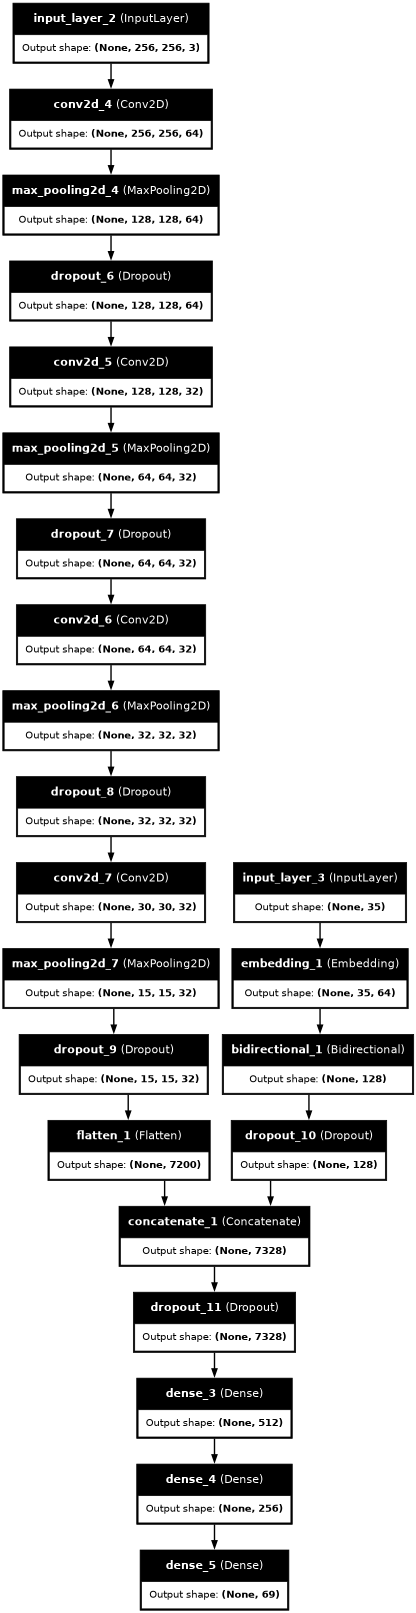

In [26]:
tf.keras.utils.plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True, dpi = 50, rankdir='LB')

In [36]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('cnn-lstm.keras',
                                                  verbose=1, save_best_only = True,
                                                monitor='val_accuracy')

history = model.fit(
    train_data,
    epochs=10,
    validation_data = val_data,
    callbacks = checkpointer
         )

Epoch 1/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3239 - loss: 2.5196
Epoch 1: val_accuracy improved from -inf to 0.43163, saving model to cnn-lstm.keras
617/617 ━━━━━━━━━━━━━━━━━━━━ 61s 93ms/step - accuracy: 0.3240 - loss: 2.5191 - val_accuracy: 0.4316 - val_loss: 1.9905
Epoch 2/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5093 - loss: 1.5029
Epoch 2: val_accuracy improved from 0.43163 to 0.50227, saving model to cnn-lstm.keras
617/617 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.5094 - loss: 1.5028 - val_accuracy: 0.5023 - val_loss: 1.5630
Epoch 3/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5938 - loss: 1.1569
Epoch 3: val_accuracy improved from 0.50227 to 0.55347, saving model to cnn-lstm.keras
617/617 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.5938 - loss: 1.1568 - val_accuracy: 0.5535 - val_loss: 1.3738
Epoch 4/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6881 - loss: 0.8669
Epoch 4: val_accuracy did not improve

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


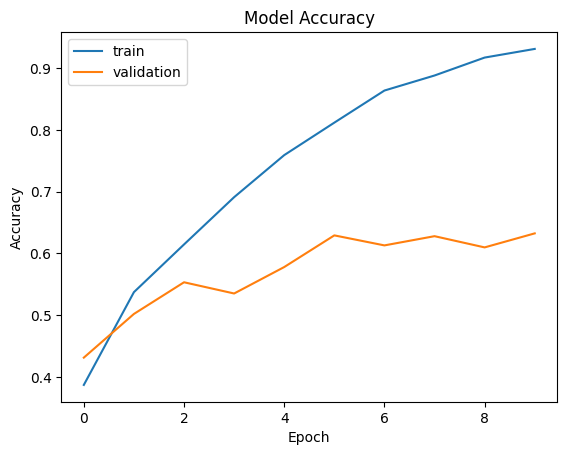

In [37]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [38]:
decoded_labels = []
for i in tqdm(range(len(testdata))):
    image_path = testdata['address'][i]
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image/255, dtype = tf.float32)
    text = testdata['question'][i]
    seq = tokenizer.texts_to_sequences([text])
    seq = pad_sequences(seq, padding = "post", maxlen = 35)
    yp = model.predict((np.expand_dims(image, axis = 0), seq), verbose = 0)
    yp = np.argmax(yp[0])
    decoded_labels.append(test_labels_df.columns[yp])
testdata["prediction"] = decoded_labels
testdata

100%|██████████| 381/381 [00:27<00:00, 14.01it/s]


,image_id,type,question,answer,address,prediction
0,synpic54082,modality,modality shown?,cta - ct angiography,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...,cta - ct angiography
1,synpic48556,modality,mri taken contrast?,no,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...,no
2,synpic50696,modality,type contrast patient have?,iv,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...,iv
3,synpic37194,modality,imaging method used?,us-d - doppler ultrasound,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...,us - ultrasound
4,synpic31308,modality,modality shown?,an - angiogram,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...,an - angiogram
...,...,...,...,...,...,...
376,synpic41140,abnormality,abnormal ct scan?,acute appendicitis,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...,yes
377,synpic19459,abnormality,abnormality seen image?,fibrous dysplasia,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...,tuberous sclerosis
378,synpic39606,abnormality,abnormality seen image?,meningioma,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...,yes
379,synpic58210,abnormality,alarming mri?,ependymoma,/kaggle/input/vqa-med-2019/VQA-Med-2019/VQAMed...,tuberous sclerosis


In [39]:
from sklearn.metrics import classification_report

rep = pd.DataFrame(classification_report(testdata['answer'], testdata['prediction'], output_dict = True))
rep

,3d reconstruction,acute appendicitis,an - angiogram,ap,arachnoid cyst,axial,bas - barium swallow,"brain, cerebral abscess",breast,contrast,...,tuberous sclerosis,ugi - upper gi,us - ultrasound,us-d - doppler ultrasound,vascular and lymphatic,xr - plain film,yes,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.666667,0.111111,0.0,0.900000,0.0,0.0,0.0,0.75,...,0.0,0.0,0.666667,0.0,0.0,0.75,0.677419,0.611549,0.323590,0.630945
recall,0.0,0.0,0.800000,0.166667,0.0,0.843750,0.0,0.0,0.0,0.50,...,0.0,0.0,0.666667,0.0,0.0,0.75,0.656250,0.611549,0.306403,0.611549
f1-score,0.0,0.0,0.727273,0.133333,0.0,0.870968,0.0,0.0,0.0,0.60,...,0.0,0.0,0.666667,0.0,0.0,0.75,0.666667,0.611549,0.299439,0.610233
support,4.0,1.0,5.000000,6.000000,0.0,64.000000,0.0,1.0,3.0,6.00,...,0.0,3.0,6.000000,1.0,3.0,12.00,32.000000,0.611549,381.000000,381.000000


In [40]:
rep[rep.T['support'].sort_values(ascending = False)[2:15].keys()]

,axial,skull and contents,no,yes,sagittal,xr - plain film,musculoskeletal,"lung, mediastinum, pleura",coronal,gastrointestinal,lateral,"face, sinuses, and neck",spine and contents
precision,0.900000,0.851852,0.685714,0.677419,0.500000,0.75,0.461538,1.000000,0.500,0.250000,0.222222,0.500000,0.666667
recall,0.843750,0.867925,0.750000,0.656250,0.800000,0.75,0.500000,0.833333,0.300,0.222222,0.250000,0.625000,0.285714
f1-score,0.870968,0.859813,0.716418,0.666667,0.615385,0.75,0.480000,0.909091,0.375,0.235294,0.235294,0.555556,0.400000
support,64.000000,53.000000,32.000000,32.000000,15.000000,12.00,12.000000,12.000000,10.000,9.000000,8.000000,8.000000,7.000000


In [41]:
rep.T['f1-score'].sort_values(ascending = False)[:20]

lung, mediastinum, pleura     0.909091
axial                         0.870968
skull and contents            0.859813
ct with gi and iv contrast    0.800000
xr - plain film               0.750000
an - angiogram                0.727273
no                            0.716418
yes                           0.666667
iv                            0.666667
us - ultrasound               0.666667
t1                            0.666667
sagittal                      0.615385
accuracy                      0.611549
weighted avg                  0.610233
contrast                      0.600000
pa                            0.600000
mr - flair                    0.571429
ct noncontrast                0.571429
face, sinuses, and neck       0.555556
heart and great vessels       0.500000
Name: f1-score, dtype: float64